# Assignment 7: Lungs detection in chest X-ray 

## Introduction
<img src="figures/xray.jpeg" width="200" height="200" align="right">
In this assignment, you are going to develop a system to automatically detect the bounding boxes surrounding the lungs in a chest X-ray scan.
For this task we are going to use a single-shot network called [Yolo](https://arxiv.org/pdf/1506.02640.pdf) (You Only Look Once). Details on the YOLO (and the more recent YOLOv2/YOLO9000) method can be found in the following papers:

  1. **You Only Look Once: Unified, Real-Time Object Detection** [https://arxiv.org/abs/1506.02640]
  2. **YOLO9000: Better, Faster, Stronger** [https://arxiv.org/abs/1612.08242] 

Chest X-ray is the most commonly acquired image in medicine. Chest X-ray uses a very small dose of ionizing radiation to produce pictures of the inside of the chest. It is used to evaluate the lungs, heart and chest wall and may be used to help diagnose shortness of breath, persistent cough, fever, chest pain or injury. It also may be used to help diagnose and monitor treatment for a variety of lung conditions such as pneumonia, emphysema and cancer. Because chest X-ray is fast and easy, it is particularly useful in emergency diagnosis and treatment.

Because of the difference in density between air, soft tissue and bone, the lungs appear much darker than their surroundings. Brighter regions in the lungs may indicate the presence of pathology.

### Teaching Assistants
- Ecem Lago: Ecem.Lago@radboudumc.nl
- Mart van Rijthoven: Mart.vanrijthoven@radboudumc.nl

Please submit your notebook via grand-challenge.org.
Submit a notebook **WITH ALL CELLS EXECUTED!!!**

* Groups: You should work in pairs or alone
* Deadline for this assignment: 
 * Thursday (March 14th) until midnight
 * 5 points (maximum grade = 100 points) penalization per day after deadline

# Tasks for this assignment 

The goal of this assignment is to get familiar with the YOLO architecture, loss function and training procedure, as well as the type of output it produces and how to transform it in actual predictions of bounding boxes. Additionally, you will get familiar with the problem of detecting lungs in chest X-ray, and the used architectures could be re-trained in the future to detect more anatomical structures in chest X-ray images.
In order to get started with the YOLO architecture, we provide you with a YOLO network pre-trained to detect only the **right lung**, which you will first run on some images and then re-train to detect both left and right lungs.

The three main tasks of this assignment are:

* Task 1: Decode the network output to visualize the predicted bounding boxes for the right lung **(30 points)**
* Task 2: Retrain the network on both lungs **(20 points)**
* Task 3: Design a simplified YOLO architecture and train it from scratch **(50 points)**

You may have noticed already that, differently from previous assignments, most of the points for your grade are at the end of the notebook. This is because the first two tasks heavily rely on code that we provide, and little changes have to be made there to get them to working. However, in the last part, a new architecture will have to be designed and re-trained, and in the notebook you will be building up knowledge and hands-on experience to understand how to design and train this network. We will propose to simplify the original YOLO architecture there (which was designed for object detection in natural images) and make a smaller one, which hopefully you can train in a smaller amount of time. More details about these tasks are provided later in this notebook.

# Data

The data used in this assignment belong to the **CHESTXRAY14** dataset, which is publicly available and can be found at this link:https://nihcc.app.box.com/v/ChestXray-NIHCC. The dataset, released by the NIH, contains 112,120 frontal-view X-ray images of 30,805 unique patients, annotated with up to 14 different thoracic pathology labels using NLP methods on radiology reports.

For this assignment, we have selected 13,331 chest X-ray images from CHESTXRAY14 and generated bounding boxes containing the left and the right lungs. The coordinates of bounding boxes are extracted from a previously obtained segmentation of the lungs, available in our research group (lung segmentation is not available in the CHESTXARY14 dataset), as depicted in the following example:

<table width="100%" border="0">
  <tr>
  <td style="text-align:center">chest x-ray image</td>
  <td style="text-align:center">lung segmentation</td>
  <td style="text-align:center">bounding box</td>
  </tr>
  <tr>
  <td><img src="figures/00000007_000.PNG" alt="" align="center" /></td>
  <td><img src="figures/00000007_000_segmentation.PNG" alt="" align="center" /></td>
  <td><img src="figures/00000007_000_overlay.PNG" alt="" align="center"/></td>

</tr>
</table>


Bounding box data come in ```xml``` format, which is the format read by the YOLO training script that we will use in this assignment (more details about this in next cells).
An example of content of ```xml``` file for bounding boxes of right and left lung for the image ```00000004_000``` is the following:

```xml
<annotation verified="no">
  <folder>Lungs</folder>
  <filename>00000004_000</filename>
  <source>
    <database>Unknown</database>
  </source>
  <size>
    <width>512</width>
    <height>512</height>
    <depth>1</depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>RL</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>64</xmin>
      <ymin>62</ymin>
      <xmax>256</xmax>
      <ymax>490</ymax>
    </bndbox>
  </object>
  <object>
    <name>LL</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>298</xmin>
      <ymin>78</ymin>
      <xmax>450</xmax>
      <ymax>502</ymax>
    </bndbox>
  </object>
</annotation>
```

Among all the parameters that you can find there, the most important ones are the following:

* ```(width, height)```: image size
* ```(RL, LL)```: labels for Right Lung and Left Lung
* ```(xmin, xmax, ymin, ymax)```: coordinates of the top-left and bottom-right corners of the bounding box

It is important that you understand these parameters now, because you will be using them in this assignment.

Let's get the data and the weights of the pre-trained network needed for this assignment. If you are working on Cartesius, the data is already available in the project space. If you are working on your computer, you will have to download data and weights.

First, let's import the libraries needed for this assignment.
The code used in this notebook is developed based on this github repository: https://github.com/experiencor/basic-yolo-keras. For this reason, we will use the same libraries used in that repository, for compatibility reasons. Therefore, you will see that we will be using the ```opencv``` library to manipulate images, which we didn't do in previous assignments. Although in the lecture this week we have seen the basic ideas of YOLO, in this assignment we will use code of YOLOv2. Do not worry about that, the main ideas of the method are the same, and the only differences that you will notice in this assignment, compared to the original YOLO, are:
* presence of skip connections in the architecture (like in ResNet)
* use of an exponential function in the prediction of width and height of bounding boxes
* normalization of width and height of anchor boxes based on grid cells size instead of image size

In [5]:
# tensorflow as base library for neural networks
import tensorflow as tf

# keras as a layer on top of tensorflow
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K

# h5py is needed to store and load Keras models
import h5py
 
# matplotlib is needed to plot bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
!pip3 install imgaug --user

import imgaug as ia # library for image augmentation, used in the repo code
from imgaug import augmenters as iaa

from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2, time, random
import xml.etree.ElementTree as ET # needed to read bounding boxes in xml format
import ntpath

# notebook-specific libraries, provided by the repo code
from preprocessing import parse_annotation, BatchGenerator, normalize
import utils

  Using cached https://files.pythonhosted.org/packages/f2/e3/4e19b465d6662e841e2960d77aa187414315b463302142a001a389cdaf2a/imgaug-0.2.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/59/de/208f66a8f57a8b32536c5f7ca5e883cb15ddae8032164ea192fa103d50f6/opencv_python-4.0.0.21-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/82/73/4fbb789c741daf2530a96c74d37f2143162c30d512e68ac6cf3bbb9bf3dc/scikit_image-0.14.2-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/af/0a/943c965d372dae0b1f1482677d29030ab834351a61a9a632fd62f27f1523/imageio-2.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a2/6c/966fa320a88fc685c956af08135855fa84a1589631256abebf73721c26ed/Shapely-1.6.4.post2-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/47/d5/efa7cacef5d3bdcd71d7053a698fb9b64a20fff5cb3c592efefa53ea5578/cloudpickle-0.8.0-py2.py3-none-any.whl
  

### Local machine


If working on your local machine, use the following cells to download the training, validation and test datasets and set your working directory.

If working on Cartesius proceed to the [next section](#cartesius).

Download **training set** and reference standard

In [ ]:
import requests
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/kwSOdtP4t3dh5vD/download'
file_name = "train_lung_detection.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./train_lung_detection.zip')

Download **test set** images.

In [ ]:
import requests
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/ZImBQSvSCpqF0i9/download'
file_name = "test_images_lung_detection.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./test_images_lung_detection.zip')

Download parameters of pre-trained network for **right lung detection**.

In [ ]:
import requests
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/LPzyrS0Tb9NgnTs/download'
file_name = "weights_right_lung.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./weights_right_lung.zip')

Download parameters of pre-trained network for **right and left lung detection**.

In [ ]:
import requests
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/0eK0ob45rmeaOyf/download'
file_name = "weights_both_lungs.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./weights_both_lungs.zip')

Download parameters of pre-trained network for **Pascal VOC** dataset.

In [ ]:
import requests
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/HGmdukdYpnyt2NV/download'
file_name = "pretrained_yolo_weights.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./pretrained_yolo_weights.zip')

In [ ]:
workdir = './'

<a id='cartesius'></a>
### Cartesius

For working on Cartesius correctly set your working directory.

In [80]:
workdir = '/projects/0/ismi2018/CHESTXRAY14/'

At this point, you will see that the structure of ```workdir``` is the following:

```python
train                        # directory of training data
  images                     # training images
  xml                        # bounding boxes of right and left lungs 
  xml_right                  # bounding boxes of only right lung
test_images                  # test images
weights_right_lung.h5        # weights of pre-trained YOLO (only right lung detection)
pretrained_yolo_weights.h5   # weights of pre-trained YOLO (VOC dataset)

```



# Task 1: Get to know the data and the YOLO network (max 30 points)

In this section, you will:
* visualize chest X-ray images from the training set
* read bounding box data from the reference standard of the right lung
* plot the bounding box

After that, you will:
* run the YOLO network, pre-trained to detect right lungs, on test images
* decode the output tensor in order to extract bounding box information
* visualize the predicted bounding box

### Load chest x-ray from training set
To get to know the data you will be working with, first load an example of a chest x-ray image from the training set and visualize it below.

**Note:** you can run the cells below multiple times to see the variability in the data! As you will notice, all images have a size of 512x512 px.

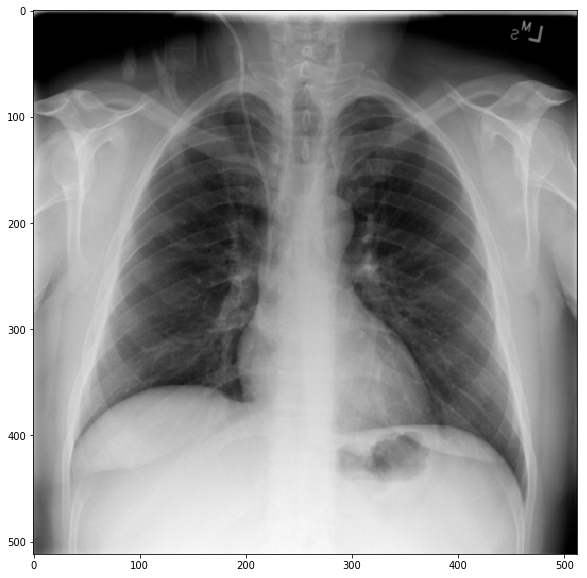

In [81]:
# define directory of training images
train_dir_images = os.path.join(workdir, 'train', 'images')

# pick random training image
case = os.path.join(train_dir_images, random.choice(os.listdir(train_dir_images)))
case_filename = os.path.splitext(ntpath.basename(case))[0] + '.xml'

# open image with opencv and visualize it
image = cv2.imread(case)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

**Q: What kind of variability do you see in training examples and what can cause it?**

There is large variability in the size, shape and relative position of the lungs as well as in their color representation in the image, with them appearing darker in some images than in others. These differences are likely caused by individual differences in lung morphologhy and by variation in the imaging setup. Additionally, there are sometimes other objects visible in the lung array, such as pacemakers.

All images in the training data are accompanied by annotations of bounding boxes that surround the right lung. Each annotation consists of a single ```xml``` file with coordinates that define the edges of the boxes (```xmin, xmax, ymin, ymax```).

Below you will find code that defines the class ```BoundBox``` that stores information of bounding boxes, but in a slightly different format, using ```(x, y)``` as the coordinates of the center of the bounding box, and ```(h, w)``` as its height and width. It also implements additional variables related to classes, scores and labels, which will become clear later in this notebook.

In [82]:
class BoundingBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

Now we define a function to read annotation in ```xml``` format and convert them into parameters to pass to the ```BoundingBox``` class. Most of the code of this function is provided, but you will have to implement the last part of it (replace the ```None``` values).

**NOTE**: as for many variables in the YOLO framework, ```(x, y, h, w)``` used in the ```BoundingBox``` class are normalized by the image height and width, meaning that they have values in the range ```[0.0, 1.0]```. Take this into account in your implementation!!!

In [83]:
def xml2bbox(xml_file):
    
    # parse structure of XML file
    tree = ET.parse(xml_file)

    for elem in tree.iter():
        if 'width' in elem.tag:
            width = int(elem.text) # image width
        if 'height' in elem.tag:
            height = int(elem.text) # image height

        for attr in list(elem):

            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(dim.text) # xmin bounding box
                    if 'ymin' in dim.tag:
                        ymin = int(dim.text) # ymin bounding box
                    if 'xmax' in dim.tag:
                        xmax = int(dim.text) # xmax bounding box
                    if 'ymax' in dim.tag:
                        ymax = int(dim.text) # ymax bounding box
    
    ### Replace None with your code ###
    # coordinate in the middle between max and min, normalized by width
    x = (xmin + xmax) / 2 / width
    y = (ymin + ymax) / 2 / height
    # difference between max and min, normalized by width
    w = (xmax - xmin) / width
    h = (ymax - ymin) / width
    print(('xmin: {}, xmax: {}, ymin: {},ymax: {}').format(xmin,xmax,ymin,ymax))
    print(('width: {}, height: {}').format(width, height))

    print(('x: {}, y: {}, w: {},h: {}').format(x,y,w,h))
    
    return BoundingBox(x,y,w,h)

Now that we have defined the ```BoundingBox``` class and the ```xml2bbox``` function, we can get the bounding box corresponding to the XML file annotation for the chosen training image:

In [84]:
anno = os.path.join(workdir, 'train', 'xml_right', case_filename)
bbox = xml2bbox(anno)

xmin: 40, xmax: 236, ymin: 78,ymax: 412
width: 512, height: 512
x: 0.26953125, y: 0.478515625, w: 0.3828125,h: 0.65234375


At this point, it is also convenient to define a function that allows us to plot bounding boxes using ```matplotlib```. We will use the ```Rectangle``` class for that. The following function reads a list of ```BoundingBox``` objects and returns a list of corresponding ```Rectangle``` objects.

In [85]:
def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        xmin  = int((box.x - box.w/2) * img_shape[1])
        xmax  = int((box.x + box.w/2) * img_shape[1])
        ymin  = int((box.y - box.h/2) * img_shape[0])
        ymax  = int((box.y + box.h/2) * img_shape[0])        
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes

Now we can use the code written so far to read, process and visualize the bounding box of the right lung together with the chest X-ray image visualized above:

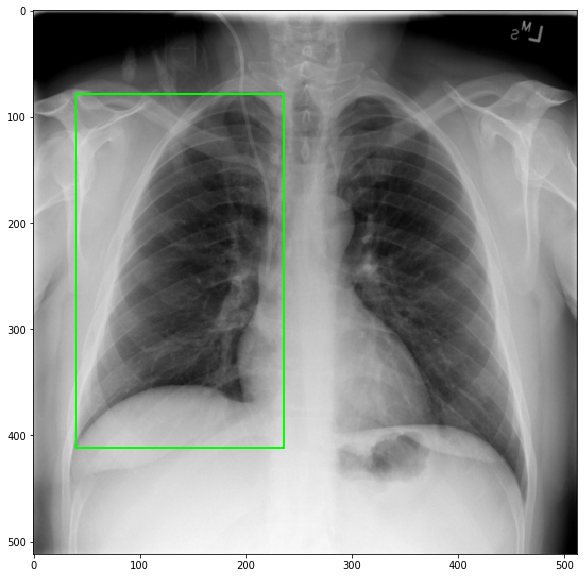

In [86]:
# get bounding boxes in matplotlib format
plt_boxes = get_matplotlib_boxes([bbox],image.shape)

# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image.squeeze(), cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

**Q: Why do we talk about right lung when the bounding box is actually on the left of the image?**

Because the image is mirrored due to the fact it was taken from the front, rather than the back.

### Load pre-trained YOLO and run it on the test dataset

We have trained a YOLO network to detect right lung in chest x-ray images already. The weights of the pre-trained network are available in the ```workdir```. We will use this pre-trained network now to get familiar with the network architecture.

#### YOLO parameters
As we learned in the lecture this week, the YOLO approach has several parameters to configure in order to learn to detect objects. All parameters are presented and explained in the YOLO and YOLO9000 (YOLOv2) papers. In particular, we know that YOLO divides the input image into a grid of cells, whose size have to be defined by the user.

The list of parameters and their short description is the following:

| Variable name| Description |
|:--------------|:----------------------------------------------------------------------------------------------|
| ```LABELS``` | List of strings about classes we want to learn (```RL``` = right lung, ```LL``` = left lung) |
| ```IMAGE_H, IMAGE_W``` | Height and width of the input image |
|```GRID_H,  GRID_W```| Number of grid cells in each dimension of the image. Grid cell size is ```(IMAGE_H/GRID_H, IMAGE_W/GRID_W)```|
| ```BOX``` | Number of boxes that a single grid cell can predict (which is the number of anchors) |
| ```CLASS``` | Number of classes |
| ```CLASS_WEIGHTS``` | Array to define the importance of each class |
| ```OBJ_THRESHOLD``` | Threshold used in final object detection |
| ```NMS_THRESHOLD``` | Threshold used in non maximal suppression |
| ```ANCHORS``` | List of coefficients of grid cell size (to be read two by two) that define the used anchors. This means that (```ANCHORS[0], ANCHORS[1]```) are the width and the height of the first anchor, (```ANCHORS[2], ANCHORS[3]```) are the widht and the height of the second anchor, etc. Differently from what presented in the original YOLO paper, and said in the lecture, anchors here are normalized by grid cell size, and not by image size, so we can have ```w >= 1.``` and ```h >= 1.```.|
| ```NO_OBJECT_SCALE``` | Part of the loss function|
| ```OBJECT_SCALE``` | Part of the loss function|
| ```COORD_SCALE``` | Part of the loss function|
| ```CLASS_SCALE``` | Part of the loss function|
| ```BATCH_SIZE``` | Mini-batch size|
| ```WARM_UP_BATCHES``` | Number of mini-batches used at the beginning of training to do warm-up (a different loss is applied) |
| ```TRUE_BOX_BUFFER``` | Used to create list of ground truth boxes, which is needed for Keras implementation|

All these parameters are set in the next cell.

In [87]:
# set the parameters for the detection of the right lung

LABELS = ['RL']

IMAGE_H, IMAGE_W = 512, 512
GRID_H,  GRID_W  = 16 , 16
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0 # lambda noobj
OBJECT_SCALE     = 5.0 # lambda obj
COORD_SCALE      = 1.0 # don't touch this
CLASS_SCALE      = 1.0 # don't touch this

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

### The YOLO network architecture

Now we define the architecture of the YOLO network, as it comes with the code in the repo, which is very close to the one in the YOLO paper, and includes some features present in the YOLO9000 paper, as for example some kind of skip connections (like in ResNet).

In [88]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [89]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [90]:
def YOLO_network(input_img,true_bxs,CLASS):

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_img)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False, input_shape=(512,512,3))(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 23
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_bxs])

    model = Model([input_img, true_bxs], output)
    
    model.summary()
    
    return model

Now we can make an instance of the YOLO network by calling the function:

In [91]:
model = YOLO_network(input_image, true_boxes, CLASS)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 512, 512, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 512, 512, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512, 512, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

### Load pretrained weights of network for right lung detection

Executing the cell below will load the weights of a model that has been trained on the right lung.

In [92]:
wt_path = os.path.join(workdir, 'weights_right_lung.h5')
model.load_weights(wt_path)
print("Weights loaded from disk")

Weights loaded from disk


Now we can try to process one image from the test set using YOLO and inspect the format of the produced output. Since images were normalized to have an intensity between 0.0 and 1.0 during training, we will apply the same normalization strategy at test time.

In [93]:
# define directory of test images
test_dir = os.path.join(workdir,'test_images')

# pick a random test file
test_img = os.path.join(test_dir, random.choice(os.listdir(test_dir)))

# process image
t_start = time.time()
print("Processing", test_img)
image = cv2.imread(test_img)
input_image = image / 255. # rescale intensity to [0, 1]
input_image = input_image[:,:,::-1]
img_shape = image.shape
input_image = np.expand_dims(input_image, 0) 

# define variable needed to process input image
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

# get output from network
netout = model.predict([input_image, dummy_array])

print('processing one chest x-ray took {} seconds'.format(time.time() - t_start))

Processing /projects/0/ismi2018/CHESTXRAY14/test_images/00012659_012.png
processing one chest x-ray took 1.6413450241088867 seconds


Let's print the ```shape``` of the tensor ```netout``` and try to understand what kind of information it contains.

In [100]:
print(netout.shape)
print(netout[0,1,1,1])

(1, 16, 16, 5, 6)
[ 2.23572     0.8518791   0.16756977 -0.09988718 -7.3144755  -0.13867377]


If you didn't change the default parameters of YOLO, you will see something like:

```(1, 16, 16, 5, 6)```

These values represent:

```(mini_batch_size, grid_h, grid_w, n_bbox, ???)```

In order to understand the meaning of the 5th dimension (which we indicate as ???), we ask you to do two things:

1. read and try to understand the content of the following function ```decode_netout()```
2. use the content of the lecture of this week, about object detection and YOLO

In [103]:
def decode_netout(netout, obj_threshold, nms_threshold, anchors, nb_class):
    """
        Decode output tensor of YOLO network and return list of BoundingBox objects.
    """
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = utils.sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * utils.softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if classes.any():
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + utils.sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + utils.sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundingBox(x, y, w, h, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if utils.bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes

**Q: What is the meaning of the 6 values in the 5th dimension of ```netout```?**

--- Your answer here ---

* ```value #1```: x coordinate of the predicted bounding box

* ```value #2```: y coordinate of the predicted bounding box

* ```value #3```: width of the predicted bounding box

* ```value #4```: height of the predicted bounding box

* ```value #5```: confidence for this bounding box prediction

* ```value #6```: class probability, in this case only for containing a right lung

Now we can put all these things together and make a function that we can use to get predicted bounding boxes for test images:

In [104]:
def predict_bounding_box(img, model, obj_threshold, nms_threshold, anchors, nb_class):
    """
        Predict bounding boxes for a given image.
    """    
    image = cv2.imread(img)
    input_image = image / 255. # rescale intensity to [0, 1]
    input_image = input_image[:,:,::-1]
    img_shape = image.shape
    input_image = np.expand_dims(input_image, 0) 

    # define variable needed to process input image
    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

    # get output from network
    netout = model.predict([input_image, dummy_array])
    
    return decode_netout(netout[0], obj_threshold, nms_threshold, anchors, nb_class)    

We use the function we just defined to process our test image and visualize the result:

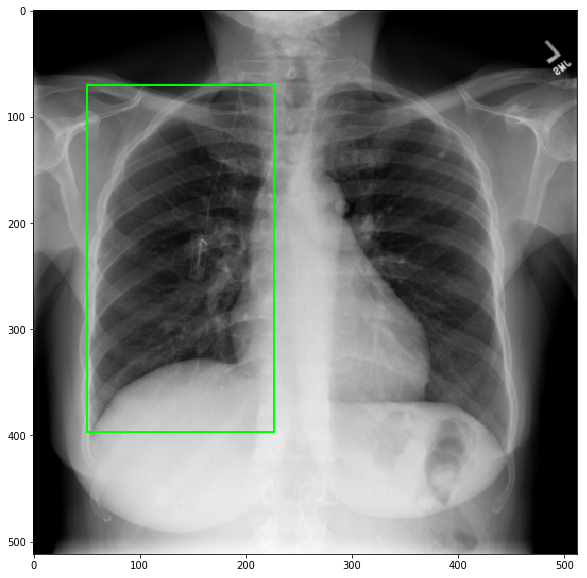

In [108]:
# define a threshold to apply to predictions
obj_threshold=0.2

boxes = predict_bounding_box(test_img, model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS)

# get matplotlib bbox objects
plt_boxes = get_matplotlib_boxes(boxes, img_shape)

# visualize result
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(cv2.imread(test_img), cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

**Q: For this first test, we used a threshold ```obj_threshold=0.2```, which results in a meaningful bounding box for the right lung. Try to see what happens if you pick a much lower threshold, for example ```obj_threshold=0.0```, or ```obj_threshold=0.001``` and explain what you see**.

**A**: For ```obj_threshold=0.0```, the whole image is plastered with mostly tiny overlapping images. For ```obj_threshold=0.001```, there are fewer boxes and the are somewhat bigger, but they still don't capture meaningful objects within the picture. This means the network detects a lot of bounding boxes, but assigns a very low confidence to them. By setting a reasonable output threshold, we can easily filter them out.

Now it would be good to check the performance of YOLO on the entire test set. Since the test set is far too large to process in this manner, if you think that the output of the cell above seems to be correct, run the cell below to process the first 50 images in the test dataset and visualize the output. Change ```obj_threshold``` to allow detection of bounding boxes with higher/lower confidence value.

processing 00012993_002.png


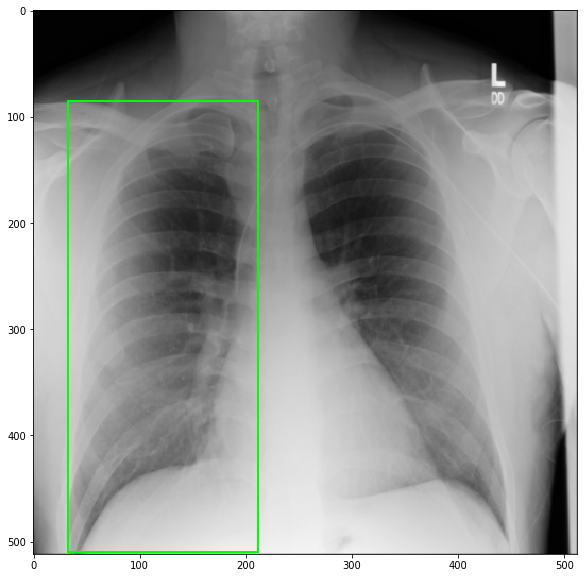

processing 00005472_002.png


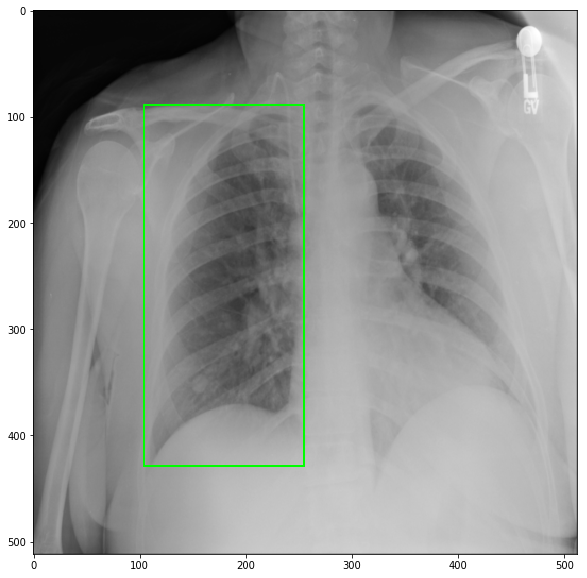

processing 00015956_014.png


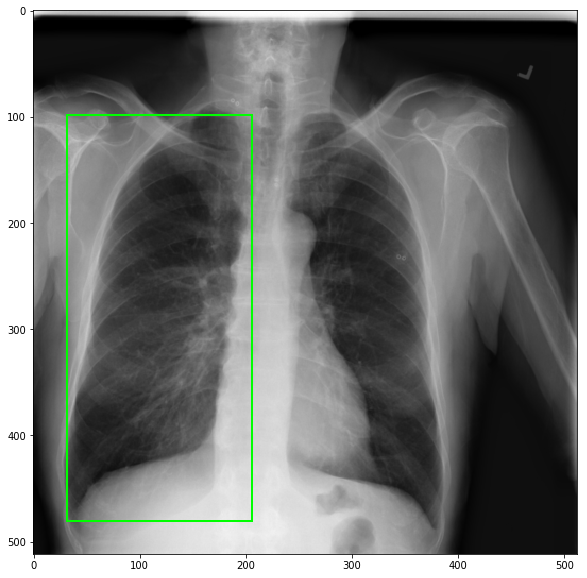

processing 00028583_006.png


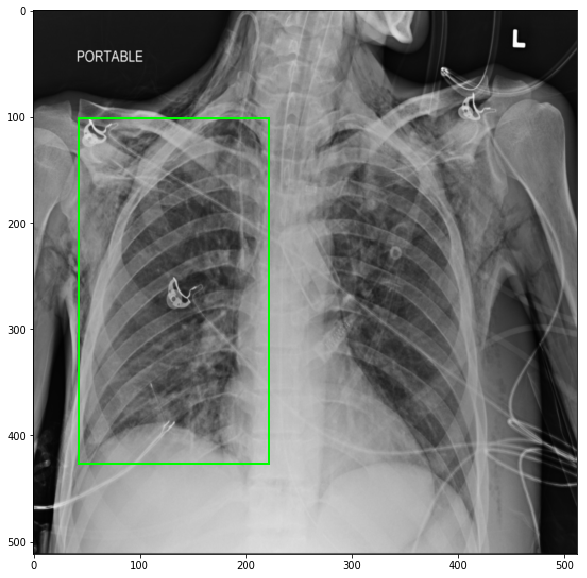

processing 00021130_002.png


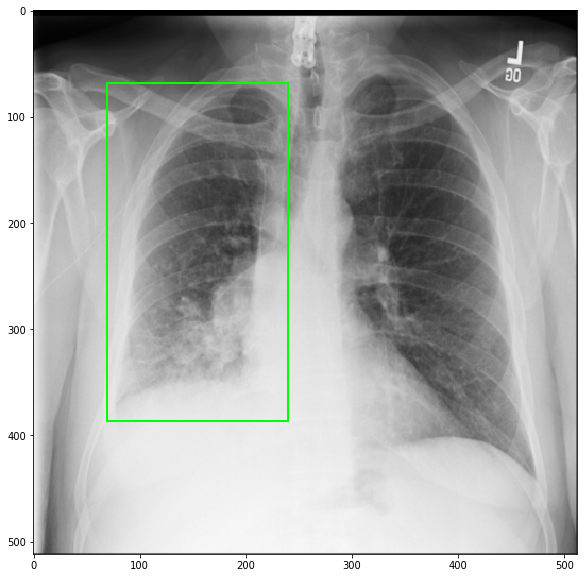

processing 00019373_008.png


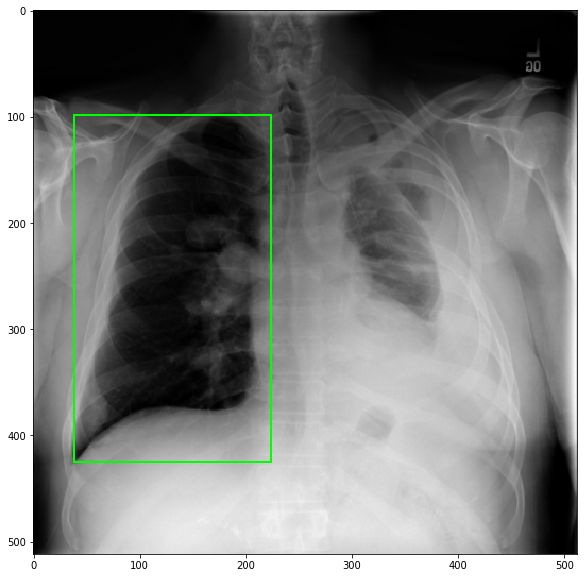

processing 00027470_006.png


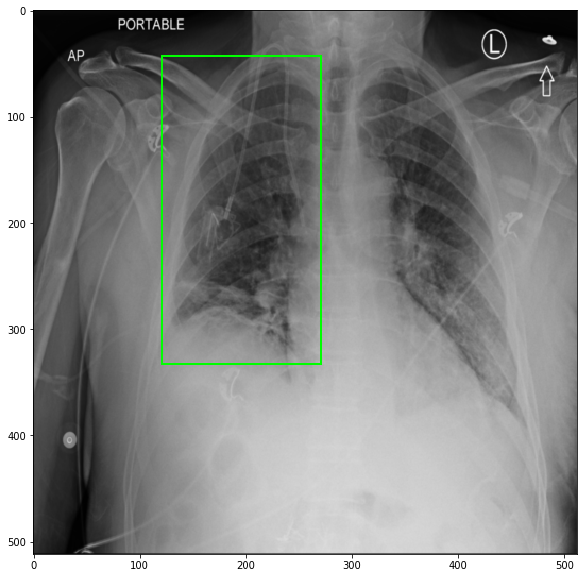

processing 00015141_004.png


In [ ]:
out_dir = './outputs'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

test_dir = os.path.join(workdir,'test_images')

file_list = os.listdir(test_dir)

obj_threshold=0.2

for t in range(50):

    test_img = os.path.join(test_dir,file_list[t])
    
    print('processing {}'.format(file_list[t]))

    boxes = predict_bounding_box(test_img, model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS)

    # get matplotlib bbox objects
    #
    plt_boxes = get_matplotlib_boxes(boxes, img_shape)

    # visualize results
    #
    fig1 = plt.figure(figsize=(10, 10))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(cv2.imread(test_img).squeeze(), cmap='gray')
    for plt_box in plt_boxes:
        ax1.add_patch(plt_box)
    plt.show()

# Task 2. Re-train YOLO to detect two lungs!
Now that we have familiarized with the data, the network architecture and the output it produces, we can start re-training YOLO to detect, this time, both lungs.

### Initialize BatchGenerator for training data
Before we start training our network, we intialize a batch generator to sample images during training, both from the training set and from the validation set, similar to what was done in the previous assignments. In this case, we will use the class ```BatchGenerator``` defined in the Github repo. This class requires two input objects:

* ```all_imgs```: list of images
* ```generator_config```: dictionary of configuration parameters

We define the ```generator_config``` first, in the next cell (we will reuse all the variables already used before, but with a "2" at the end, when needed, indicating that this time it is for 2 lungs):

In [ ]:
# define configuration parameters for batch generator

LABELS2 = ['RL','LL'] # RL = right lung, LL = left lung

CLASS2            = len(LABELS2)
CLASS_WEIGHTS2    = np.ones(CLASS2, dtype='float32')

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS2,
    'CLASS'           : len(LABELS2),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [ ]:
input_image_2 = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes_2  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

model_2 = YOLO_network(input_image_2, true_boxes_2, CLASS2)

Here we define the list of images ```all_imgs``` by reading all training images and corresponding annotations. This may take a while, because we have 10,000 training images!

In [ ]:
# extract list of images and corresponding annotations

image_path = os.path.join(workdir, 'train', 'images/')
annot_path = os.path.join(workdir, 'train', 'xml/')

all_imgs, seen_labels = parse_annotation(annot_path, image_path)

Initialize ```BatchGenerator``` for training and validation sets. In order to do that, we have to define the percentage of data we want to use for training and for validation.

In [ ]:
# define percentage of data to use for training
training_data_percentage = None # set a number between 0 and 1

# define number of training images
train_valid_split = int(training_data_percentage * len(all_imgs))

# initialize training and validation batch generators
train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=utils.normalize)
valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=utils.normalize)

### Loss function
We have seen in the lecture that the YOLO network has a loss function that contains several elements. Here we report the formula of the loss function, and also its implementation as provided with the repo code. As you will see, it's a quite long and complex piece of code. We report the formula and the code here for completeness, but you don't have to worry too much about it now, just use it!

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [ ]:
def loss(y_true, y_pred):
    """
        A custom loss is defined for YOLO, which is not implemented in Keras.
    """
    
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes_2[..., 0:2]
    true_wh = true_boxes_2[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS2, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

Next to defining the loss function, we define some extra information that is useful during training, namely a criterion for early stopping, to avoid overfitting of the network, and another criterion for saving the weights of the best network during training, namely the one that minimized the validation loss. The weights of that network will be saved as ```weights_left_right_lung.h5```.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_left_right_lung.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

### Load weights of network pre-trained on Pascal VOC data
The YOLO network that we have inialized has random initial parameters. However, we know that YOLO was originally presented to process images in the Pascal VOC dataset, to tackle object detection in natural images with 20 different classes. You can imagine that a lot of information about structures that you can find in images, ranging from edges and corners to more complex structures like the ones you find in natural images, has been learned by the network already. For this reason, it is often a good idea to use a "pre-trained" network, by loading the parameters that have been learned from another dataset. In this case, we have the parameters of YOLO trained on Pascal VOC available, and we will load them now.

In [ ]:
# path to file of Pascal VOC YOLO weights
wt_path2 = os.path.join(os.getcwd(), 'pretrained_yolo_weights.h5')
model_2.load_weights(wt_path2)
print("Weights loaded from disk")

## Train the network
So far, we have:
* made an instance of the YOLO network
* loaded weights of YOLO pre-trained on Pascal VOC
* defined a loss function
* defined training set and validation set for detection of left and right lungs
* defined batch generator for training and validation set

Now we are ready to train our network!

In the next cell, we suggest some values for the number of epochs and for the learning rate. Try to use these two values at first, which can be useful to (1) get quite stable loss values (we have seen that high learning rates often give NaN or very high loss values), and (2) realize how long it takes to train YOLO (using the current settings on cartesius should take ~ 15 minutes/epoch!).

In [ ]:
# define number of epochs
n_epoch = 2
learning_rate = 1e-5

# define a folder where to store log files during training
logwrite = './logs'
if not os.path.exists(logwrite):
    os.makedirs(logwrite)

# Define Adam optimizer
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

# compile YOLO model
model_2.compile(loss=loss, optimizer=optimizer)

# do training!
model_2.fit_generator(generator   = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = n_epoch, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

After training for few epochs, we can apply the network to a randomly sampled image from the test set, and check whether the result makes sense. Adjust the value ```obj_threshold``` to get the best output from YOLO, out of all bounding boxes detected.

In [ ]:
# read from test set
test_dir = os.path.join(workdir,'test_images')
test_file_list = os.listdir(test_dir)
img_index = np.random.randint(0, len(test_file_list))
test_img = cv2.imread(os.path.join(test_dir, test_file_list[img_index]))

# define a threshold to apply to predictions
obj_threshold=0.01

# predict bounding boxes using YOLO model2
boxes = predict_bounding_box(os.path.join(test_dir, test_file_list[img_index]), model_2, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS2)
print(test_file_list[img_index])
# get matplotlib bbox objects
plt_boxes = get_matplotlib_boxes(boxes, test_img.shape)

# visualize result
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(test_img, cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

At this point, if you have trained YOLO for only few epochs, you have probably realized that the performance is not good. We did some experiments with the current architecture and we saw that after training for ~ 20 epochs, the performance is actually very good! So at this point you have two choices: (1) you can train the current architecture for ~ 5 hours, which may be a task for Cartesius to do overnight, or (2) see what the performance could be by loading the weights of YOLO trained to detect the two lungs, which we did for you already! You can load those weights by executing the next cell.

In [ ]:
# path to file of Pascal VOC YOLO weights
wt_path2 = os.path.join(os.getcwd(), 'weights_both_lungs.h5')
model_2.load_weights(wt_path2)
print("Weights loaded from disk")

Now you can test images again and check if the predictions make sense. The difference between the network you trained yourself for few epochs and the one you just loaded is just the training time! In this case, just training longer improves the performance.

In [ ]:
# read from test set
test_dir = os.path.join(workdir,'test_images')
test_file_list = os.listdir(test_dir)
img_index = np.random.randint(0, len(test_file_list))
test_img = cv2.imread(os.path.join(test_dir, test_file_list[img_index]))

# define a threshold to apply to predictions
obj_threshold=0.01

# predict bounding boxes using YOLO model2
boxes = predict_bounding_box(os.path.join(test_dir, test_file_list[img_index]), model_2, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS2)
print(test_file_list[img_index])
# get matplotlib bbox objects
plt_boxes = get_matplotlib_boxes(boxes, test_img.shape)

# visualize result
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(test_img, cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

# Task 3: Make your own YOLO! (50 points)

The main message of the steps of this assignment so far is that YOLO is a powerful architecture for object detection, and that it works very well for lungs detection in chest x-ray images, but training is somehow slow, and the architecture is quite deep.
Moreover, several parameters that you have used so far were specifically tuned to address the object detection problem in the Pascal VOC dataset. Things like number of boxes, or anchor boxes, or grid cells may not be ideal for the problem at hand.
Finally, you may wonder whether this quite deep architecture (23 layers) is really needed for the task of lung detection. Consider that this network was originally designed to detect 20 different classes in natural images, with objects at multiple scales, multiple shape, etc. In the field of chest x-ray, images are always the same size, and lungs can be expected in more or less the same position and comparable size/shape. Therefore, the number of bonding/anchor boxes that you can use can be tuned, as well as the shape of anchor boxes.

The steps we propose for this task are the following:

1. Think about the best choice for bounding boxes and anchor boxes, and define new values for the variables ```BOX``` and ```ANCHORS```.
2. Think about a good choice for grid cells to use, and modify the variables ```GRID_H, GRID_W``` accordingly
3. Define a simpler network architecture, meaning with fewer parameters (it could be shallower, or just with fewer filters per layer, or both), and train it to detect both lungs. You will have to do this with random initialization, because now pre-trained weights cannot be applied anymore!

In case you have problems getting a good convergence, try to use your knowledge to make things work better (regularization, different optimizer, etc.)

Do not modify previous cells, but re-use previous code by copying to the next cell (and add more cells if needed).

In [ ]:
### YOUR CODE HERE. DO NOT MODIFY PREVIOUS CELLS! JUST COPY THE CODE THAT IS NEEDED TO INITIALIZE AND TRAIN THE NETWORK

### Submit results to grand-challenge.org
Now that you have trained your YOLO architecture, you can process the entire test set, save the predicted bounding boxes in a ```CSV``` file, and submit your results to grand-challenge.org. The results you will submit consist of the coordinates of top-left and bottom-right corners of bounding boxes for left and right lungs. The function in the next cell does the conversion of these coordinates from ```BoundingBox``` objects to a ```CVS``` file.

In [ ]:
def bbox2csv(image, filename, boxes, csv_file):
    
    csv_out = open(csv_file, 'a')
    
    line = filename.split('.')[0] #+ ',' + str(image.shape[1]) + ',' + str(image.shape[0])
    
    if boxes: # At least one bounding box is found.

        maxL = -1
        posL = -1
        maxR = -1
        posR = -1
        for idx, box in enumerate(boxes):
            if box.get_label()==0:
                if box.get_score()>maxR:
                    maxR = box.get_score()
                    posR = idx
            if box.get_label()==1:
                if box.get_score()>maxL:
                    maxL = box.get_score()
                    posL = idx
        
        if posR>=0: # Bounding box for right lung.
            box = boxes[posR]

            xmin  = int((box.x - box.w/2) * img_shape[1])
            xmax  = int((box.x + box.w/2) * img_shape[1])
            ymin  = int((box.y - box.h/2) * img_shape[0])
            ymax  = int((box.y + box.h/2) * img_shape[0])

            line = line + ',' + str(xmin) + ',' + str(ymin) + ',' + str(xmax) + ',' + str(ymax)
        else: # No bounding box for right lung.
            line = line + ',' + str(0) + ',' + str(0) + ',' + str(0) + ',' + str(0)
            
        if posL>=0: # Bounding box for left lung.
            box = boxes[posL]

            xmin  = int((box.x - box.w/2) * img_shape[1])
            xmax  = int((box.x + box.w/2) * img_shape[1])
            ymin  = int((box.y - box.h/2) * img_shape[0])
            ymax  = int((box.y + box.h/2) * img_shape[0])

            line = line + ',' + str(xmin) + ',' + str(ymin) + ',' + str(xmax) + ',' + str(ymax)
        else: # No bounding box for left lung.
            line = line + ',' + str(0) + ',' + str(0) + ',' + str(0) + ',' + str(0)
    else:
        ## If no boxes detected == No lungs detected
        line = line + ',' + str(0) + ',' + str(0) + ',' + str(0) + ',' + str(0)
        line = line + ',' + str(0) + ',' + str(0) + ',' + str(0) + ',' + str(0) 
    csv_out.write(line + '\n')
    csv_out.close()

Now you can use this function to create the CSV file to submit:

In [ ]:
out_dir = './outputs'

test_dir = os.path.join(workdir,'test_images')

file_list = os.listdir(test_dir)

header = 'filename,RL_xmin,RL_ymin,RL_xmax,RL_ymax,LL_xmin,LL_ymin,LL_xmax,LL_ymax\n'
csv_file = os.path.join(outdir,'test_set.csv')

with open(csv_file, 'w') as csv_out:
    csv_out.write(header)

for t in tqdm.tqdm(range(len(file_list))):

    test_img = os.path.join(test_dir,file_list[t])

    image = cv2.imread(test_img)
    input_image = image / 255.
    input_image = input_image[:,:,::-1]
    img_shape = image.shape
    input_image = np.expand_dims(input_image, 0) 

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

    netout = model_2.predict([input_image, dummy_array])

    # decode the output of the network to obtain bounding box
    #
    boxes = decode_netout(netout[0], 
                          obj_threshold=0.5,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS2)
        
    bbox2csv(image, file_list[t], boxes, csv_file)

#### Submit your results

You can now download this csvfile with this link: [test_set.csv](test_set.csv).  
Next, upload your result to the challenge website (https://ismi-chestxray.grand-challenge.org/) and see how well you performed compared to your fellow students! You can submit as often as you want, only the best result counts.  